In [1]:
# custom notebook:
# original file used: spacex_dash_app.py
# custom feature used: JupyterDash plugin for Jupyter Lab

## Build a Dashboard Application with Plotly Dash ##

In this lab, you will be building a Plotly Dash application for users to perform interactive visual analytics on SpaceX launch data in
real-time.

This dashboard application contains input components such as a dropdown list and a range slider to
interact with a pie chart and a scatter point chart. You will be guided to build this dashboard application via the following tasks:

* TASK 1: Add a Launch Site Drop-down Input Component

* TASK 2: Add a callback function to render success-pie-chart based on selected site dropdown

* TASK 3: Add a Range Slider to Select Payload

* TASK 4: Add a callback function to render the success-payload-scatter-chart scatter plot

Note:Please take screenshots of the Dashboard and save them. Further upload your notebook to github.

The github url and the screenshots are later required in the presentation slides.

In [2]:
from jupyter_dash import JupyterDash

In [3]:
# Import required libraries
import pandas as pd
from jupyter_dash import JupyterDash    # custom code: JupyterDash replacing Dash on Jupyter Lab
import dash
from dash import html    # custom note: import dash_html_components as html ← deprecated
from dash import dcc     # custom note: import dash_core_components as dcc ← deprecated
from dash.dependencies import Input, Output
import plotly.express as px

# Read the airline data into pandas dataframe
spacex_df = pd.read_csv("spacex_launch_dash.csv")
max_payload = spacex_df['Payload Mass (kg)'].max()    # custom note: to be used in task 3
min_payload = spacex_df['Payload Mass (kg)'].min()    # custom note: to be used in task 3

# Create a dash application
app = JupyterDash(__name__)    # custom code: over → app = dash.Dash(__name__)

# Create an app layout
app.layout = html.Div(
    children=[
        html.H1(
            'SpaceX Launch Records Dashboard',
            style={
                'textAlign': 'center',
                'color': '#503D36',
                'font-size': 40
            }
        ),
        
        # TASK 1: Add a dropdown list to enable Launch Site selection
        # The default select value is for ALL sites
        dcc.Dropdown(
            id='site-dropdown',
            options=[
                {
                'label': 'All Sites',
                'value': 'ALL'
                },
                {
                'label': 'CCAFS LC-40',
                'value': 'CCAFS LC-40'
                },
                {
                'label': 'CCAFS SLC-40',
                'value': 'CCAFS SLC-40'
                },
                {
                'label': 'KSC LC-39A',
                'value': 'KSC LC-39A'
                },
                {
                'label': 'VAFB SLC-4E',
                'value': 'VAFB SLC-4E'
                },
            ],
            value='ALL',
            placeholder='Select a Launch Site',
            searchable=True
        ),
        html.Br(),
        
        # TASK 2: Add a pie chart to show the total successful launches count for all sites
        # If a specific launch site was selected, show the Success vs. Failed counts for the site
        html.Div(
            dcc.Graph(
                id='success-pie-chart'
            )
        ),
        html.Br(),
        
        html.P("Payload range (Kg):"),
        # TASK 3: Add a slider to select payload range
        dcc.RangeSlider(
            id='payload-slider',
            min=0,
            max=10000,
            step=100,
            value=[
                min_payload,
                max_payload
            ],
            marks={
                0: '0',
                2500: '2500',
                5000: '5000',
                7500: '7500',
                10000: '10000'
            },
        ),
        
        # TASK 4: Add a scatter chart to show the correlation between payload and launch success
        html.Div(
            dcc.Graph(
                id='success-payload-scatter-chart'
            )
        ),
    ],
    style={'font-family': 'sans-serif', 'background-color' : 'transparent'}    # custom note: font style set to sans-serif
)

# TASK 2:
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
@app.callback(
    Output(
        component_id='success-pie-chart',    #custom note: from html.Div(dcc.Graph(id='success-pie-chart')), above
        component_property='figure'
    ),
    Input(
        component_id='site-dropdown',    # custom note: from id='site-dropdown' above
        component_property='value'    # custom note: from options=[...'value':] above 
    )
)


def pie_chart(launch_site):
    sites_all = spacex_df[['Launch Site', 'class']]    # data
    # sites_all = launch_df.groupby('Launch Site').sum().reset_index()
    sites_one = sites_all[sites_all['Launch Site']==launch_site]    # custom note: filtering based on picked value
    sites_one = sites_one.value_counts().to_frame('count').reset_index()    # custom note: count 0/1 outcomes ('count')
    sites_one = sites_one.replace([0, 1], ['unsuccessful', 'successful'])    # custom note: (re)naming the outcome labels
    
    if launch_site == 'ALL':
        # If ALL sites are selected: render and return a pie chart graph to show the total success launches
        fig = px.pie(
            sites_all,
            names='Launch Site',
            values='class',
            hover_data=['Launch Site'],
            title='Total Success By Site'
        )
        # custom code - transparent background
        fig.update_layout({
            'plot_bgcolor': 'rgba(0, 0, 0, 0)',
            'paper_bgcolor': 'rgba(0, 0, 0, 0)'
        })
        return fig
    else:
        # # If a specific launch site is selected: return the outcomes piechart for a selected site
        fig = px.pie(
            sites_one,
            names='class',
            values='count',
            hover_data=['class'],
            title=f'Total Success Launches for site {launch_site}'
        )
        # custom code - transparent background
        fig.update_layout({
            'plot_bgcolor': 'rgba(0, 0, 0, 0)',
            'paper_bgcolor': 'rgba(0, 0, 0, 0)'
        })
        return fig

# TASK 4:
# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output
@app.callback(
    Output(
        component_id='success-payload-scatter-chart',     # dcc.Graph(id='success-payload-scatter-chart')
        component_property='figure'
    ),
    [
        Input(
            component_id='site-dropdown',    # launch site
            component_property='value'        
        ),
        Input(
            component_id='payload-slider',    # payload range
            component_property='value'
        )
    ]
)


def scatter_plot(launch_site, payload_range):
    payload_lo, payload_hi = payload_range
    sites_all = spacex_df[['Launch Site', 'class', 'Payload Mass (kg)','Booster Version Category']]
    sites_all = sites_all[(sites_all['Payload Mass (kg)']>payload_lo) & (sites_all['Payload Mass (kg)']<payload_hi)]
    sites_one = sites_all[sites_all['Launch Site'] == launch_site]
    
    if launch_site == 'ALL':
        # If ALL sites are selected: render a scatter plot to display all values for variable Payload Mass (kg) and variable class            
        fig = px.scatter(
            sites_all,
            x='Payload Mass (kg)',
            y='class',
            color='Booster Version Category',
            hover_data=['Booster Version Category'],
            title = f'Correlation between Payload and Success for all Sites ({payload_lo}-{payload_hi}Kg)'
        )
        # custom code - transparent background
        fig.update_layout({
            'plot_bgcolor': 'rgba(0, 0, 0, 0)',
            'paper_bgcolor': 'rgba(0, 0, 0, 0)'
        })
        return fig
    
    else:
        # If a specific launch site is selected: render a scatter chart to show values Payload Mass (kg) and class for the selected site
        pass
        fig = px.scatter(
            sites_one,
            x='Payload Mass (kg)',
            y='class',
            color='Booster Version Category',
            hover_data=['Booster Version Category'],
            title = f'Correlation between Payload and Success for site {launch_site} ({payload_lo}-{payload_hi}Kg)'
        )
        # custom code - transparent background
        fig.update_layout({
            'plot_bgcolor': 'rgba(0, 0, 0, 0)',
            'paper_bgcolor': 'rgba(0, 0, 0, 0)'
        })
        return fig        
    

# Run the app
if __name__ == '__main__':
    app.run_server(mode='inline')    # custom code: mode set to 'inline' in order to be used in Jupyter Lab

Dash is running on http://127.0.0.1:8050/



In [4]:
# Finding Insights Visually
# Now with the dashboard completed, you should be able to use it to analyze SpaceX launch data,
# and answer the following questions:

# 1. Which site has the largest successful launches?
# 2. Which site has the highest launch success rate?
# 3. Which payload range(s) has the highest launch success rate?
# 4. Which payload range(s) has the lowest launch success rate?
# 5. Which F9 Booster version (v1.0, v1.1, FT, B4, B5, etc.) has the highest launch success rate?

In [6]:
# custom cell
import matplotlib.pyplot as plt
import seaborn as sns

launch_df = spacex_df[['Launch Site', 'class']]

In [18]:
# custom cell

boosters = spacex_df[['Booster Version Category', 'class']]
boosters_count = boosters.groupby('Booster Version Category').count()    #.reset_index()
boosters_sum = boosters.groupby('Booster Version Category').sum()    #.reset_index()

# boosters_count.head()
# boosters_sum.head()

In [19]:
boosters_count.rename(columns={'class': 'launches'}, inplace=True)
boosters_count.sort_values(
    by='launches',
    ascending=False,
    inplace=True
)
boosters_count

,launches
Booster Version Category,
FT,24
v1.1,15
B4,11
v1.0,5
B5,1


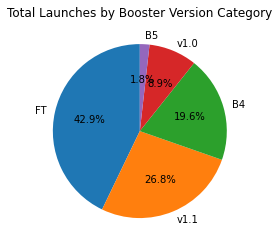

In [20]:
plt.pie(
    boosters_count['launches'],
    labels = boosters_count.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Total Launches by Booster Version Category')

plt.savefig('z_3_2_4-total_launches_by_booster_version_category.png')
plt.show()

In [21]:
boosters_sum.sort_values(
    by='class',
    ascending=False,
    inplace=True
)
boosters_sum

,class
Booster Version Category,
FT,16
B4,6
B5,1
v1.1,1
v1.0,0


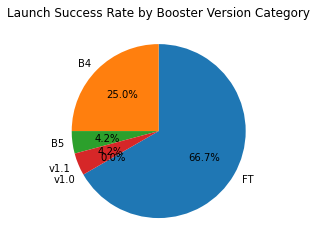

In [22]:
explode = (0, 0, 0, 0, 0) 

plt.pie(
    boosters_sum['class'],
    labels = boosters_sum.index,
    autopct='%1.1f%%',
    explode=explode,
    startangle=210,
)
plt.title('Launch Success Rate by Booster Version Category')

plt.savefig('z_3_2_4-total_launch_success_rate_by_booster_version_category.png')
plt.show()

In [23]:
boosters_concat = pd.concat([boosters_count, boosters_sum], axis=1)
boosters_concat

,launches,class
FT,24,16
v1.1,15,1
B4,11,6
v1.0,5,0
B5,1,1
